In [1]:
# Utils
import os, sys, re, time, gc, types, string, unicodedata, unidecode, string, warnings, inspect

#import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import time
import pickle
import re, sys, unidecode

from sklearn.metrics import accuracy_score
from IPython.display import display, Markdown, Latex

import shutil
import os

# Representation
import nltk
from nltk.corpus import stopwords

import wordbatch
from wordbatch.extractors import WordBag, WordHash
from wordbatch.models import FTRL

#plt.style.use('fivethirtyeight')

#Carga stop word
#nltk.download('stopwords')
spanish_stopwords = nltk.corpus.stopwords.words('spanish')

# punkt:  módulo contiene modelos para la tokenización de textos
#nltk.download('punkt')

/root/anaconda3/lib/python3.6/site-packages/randomstate-1.14.0-py3.6-linux-x86_64.egg/randomstate/__init__.py:66: RandomStateDeprecationWarning: 
**End-of-life notification**

This library was designed to bring alternative generators to the NumPy 
infrastructure. It as been successful in advancing the conversation 
for a future implementation of a new random number API in NumPy which 
will allow new algorithms and/or generators. The next step
in this process is to separate the basic (or core RNG) from the 
functions that transform random bits into useful random numbers.
This has been implemented in a successor project  **randomgen** 
available on GitHub

https://github.com/bashtage/randomgen

or PyPi

https://pypi.org/project/randomstate/.

randomgen has a slightly different API, so please see the randomgen documentation

https://bashtage.github.io/randomgen.

  warnings.warn(DEPRECATION_MESSAGE, RandomStateDeprecationWarning)


# Parameters

In [2]:
root_path = "../"
path_data_clean = root_path + "data/clean/"
path_model = root_path + 'models/'
features_path = root_path + 'data/features/'
model_name = "test"
path_model += model_name

delete_old_model = True
if delete_old_model:
    try:
        os.system("rm -rf "+path_model)
        os.system("mkdir "+path_model)
    except:
        print("error")

# Load Data

In [3]:
dfNoticias = pd.read_pickle(path_data_clean + "/dfNoticiasClean.p")


In [4]:
dfNoticias.head()

,Cuerpo,Fecha,Hora,ID,Resumen,Seccion_1,Seccion_2,Seccion_3,Subtema_1,Subtema_2,Subtema_3,Tema_1,Tema_2,Tema_3,Titular,Type
1,\nMarcel Granollers (44°) sorprendió a David F...,20140929,09:57,20140929095927,\nEl español cayó ante su compatriota Marcel G...,deportes,None,None,torneos atp,None,None,tenis,None,None,\nDavid Ferrer sufrió otra temprana eliminación\n,fid_noticia
2,\nEl Gobierno de Barack Obama ha enviado cuatr...,20140929,07:03,20140929065051,\nLas conversaciones comenzaron el año 2010 y ...,pais,mundo,mundo,eeuu,relaciones exteriores,None,relaciones exteriores,eeuu,cuba,\nObama ha enviado cuatro solicitudes a Chile ...,fid_noticia
3,\nEste miércoles la Comisión Asesora Presidenc...,20140929,11:37,20140929105234,\nRepresentantes del sector privado acusaron q...,pais,None,None,isapre,None,None,salud,None,None,\nQuiebre en comisión presidencial de isapres ...,fid_noticia
4,"\nWolfgang Burmann, del Team Avanti, se adjudi...",20140929,10:05,20140929100825,\nEl pedalero del equipo Avanti terminó en el ...,deportes,None,None,chilenos,None,None,ciclismo,None,None,\nWolfgang Burmann ganó el segundo clasificato...,fid_noticia
6,"\nEl Gobierno, a través de Sernapesca, present...",20140929,15:47,20140929152501,\nBachelet instruyó a los ministros de Economí...,pais,pais,None,None,None,None,medioambiente,region de valparaiso,None,\nGobierno presentó querella por derrame de pe...,fid_noticia


# pre procesing



In [5]:
_map = {}
_map["Cuerpo"] = []
_map["Seccion"] = []
_map["Tema"] = []
_map["Subtema"] = []

count = 0
for index, row in dfNoticias.iterrows():    
    _map["Cuerpo"].append(row["Cuerpo"]) 
    _map["Seccion"].append(row["Seccion_1"])
    _map["Tema"].append(row["Tema_1"])
    _map["Subtema"].append(row["Subtema_1"])

df = pd.DataFrame(_map)
# Elimino clase corporativo, muy pocos ejemplos
df = df[df.Seccion != "corporativo"]

    
X_untransformed = df['Cuerpo'].reset_index(drop=True)
y1 = df['Seccion'].reset_index(drop=True)
y2 = df['Tema'].reset_index(drop=True)
y3 = df['Subtema'].reset_index(drop=True)


# Feature Extraccion

### Data representation
* Normalisacion
* TFID calculation

In [6]:
from nltk.stem.snowball import SnowballStemmer

def normalize_text(text):
    """ Funcion de normalizacion """    
    # split into words
    tokens = nltk.tokenize.word_tokenize(text,language='spanish', preserve_line=False)
    # convert to lower case
    tokens = [w.lower() for w in tokens]    
    
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    
    # remove remaining tokens that are n<<<<<<<<<<<<<<<<<<<<<
    words = [word for word in stripped if word.isalpha()]
    
    # stop word and remove accent
    def strip_accents(s):
        return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
    stop_words = set(spanish_stopwords)
    words = [strip_accents(w) for w in words if not w in stop_words]
#    return u" ".join(words)
    
    stemmer = SnowballStemmer("spanish")
    out = ""
    for word in words:
        out += stemmer.stem(word)+" "    
    return out
    

# spanish_stopwords = stopwords.words('spanish')
# def normalize_text(text):
#     return u" ".join([x for x in [y for y in text.lower().strip().split(" ")] 
#                       if len(x) > 1 and x not in spanish_stopwords])

In [122]:

start = time.time()
print("start")


X_untransformed = X_untransformed
n_docs = X_untransformed.shape[0]
n_cpu = 40

batch_size = int(n_docs/n_cpu)

#'log', "idf":50.0
wb = wordbatch.WordBatch(normalize_text, 
                         extractor=(WordBag, {"hash_ngrams": 1, "hash_ngrams_weights": [1.0, 1.0],
                                              "hash_size": 2**28, "norm": "l2", "tf": 1.0,
                                              "idf": 1.0}), procs=n_cpu, n_words=10000, minibatch_size=batch_size)

# add method="serial" to extractor for debug normalize function

wb.dictionary_freeze = True
word_comment = wb.fit_transform(list(X_untransformed),reset= False)

# revisar esta normalizacion
X_transformed = word_comment[:, np.array(np.clip(word_comment.getnnz(axis=0) - 1, 0, 1), dtype = bool)]

end = time.time()
print("TFIDF end time :" + str(end - start) )

X = X_transformed

#X = X.todense()
print('Number of features: {}'.format(X.shape[1]))



start
Normalize text
Extract wordbags
TFIDF end time :122.6968686580658
Number of features: 10000


In [12]:
type(X)

scipy.sparse.csr.csr_matrix

In [ ]:
from sklearn.decomposition import TruncatedSVD


svd = TruncatedSVD(sr)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_tfidf = sparse.load_npz(modelsPath+"/"+dSet+"_"+modelVec+"-"+vParam+".npz")
X_train_lsa = lsa.fit_transform(X_tfidf)

In [100]:
from sklearn.decomposition import TruncatedSVD


test = X[0:299,:]

In [124]:
start = time.time()

svdT = TruncatedSVD(n_components=1000)
svdTFit = svdT.fit_transform(X)
end = time.time()

print("end time :" + str(end - start) )


end time :296.6265561580658


In [84]:
start = time.time()
u, s, vh = np.linalg.svd(test.todense())
end = time.time()
print("end time :" + str(end - start) )


end time :3.242626667022705


In [64]:
vh.shape

(1000, 1000)

In [52]:
type(test)

scipy.sparse.csr.csr_matrix

In [112]:
import numpy, scipy.sparse
from sparsesvd import sparsesvd
mat = test
start = time.time()

smat = scipy.sparse.csc_matrix(test) # convert to sparse CSC format
ut, s, vt = sparsesvd(smat, 1000) # do SVD, asking for 100 factors
end = time.time()
print("end time :" + str(end - start) )

ut.shape

end time :0.1241757869720459


(299, 299)

In [113]:
from scipy.sparse.linalg import svds, eigs
start = time.time()

A = X
u, s, vt = svds(A, k=1000)
end = time.time()
print("end time :" + str(end - start) )


end time :244.7322473526001


In [114]:
u.shape

(238818, 1000)

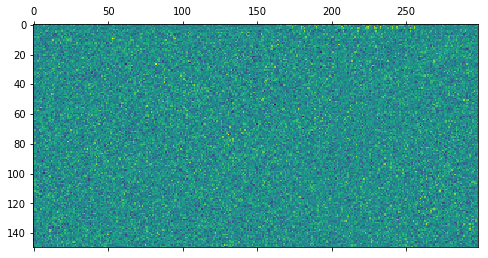

In [78]:
numpy.allclose(mat, numpy.dot(ut.T, numpy.dot(numpy.diag(s), vt)))

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [67]:
type(smat)

scipy.sparse.csc.csc_matrix

(10000, 1000)

In [60]:
ut.shape

(100, 10000)

In [36]:
help(np.linalg.svd)

Help on function svd in module numpy.linalg.linalg:

svd(a, full_matrices=True, compute_uv=True)
    Singular Value Decomposition.
    
    When `a` is a 2D array, it is factorized as ``u @ np.diag(s) @ vh
    = (u * s) @ vh``, where `u` and `vh` are 2D unitary arrays and `s` is a 1D
    array of `a`'s singular values. When `a` is higher-dimensional, SVD is
    applied in stacked mode as explained below.
    
    Parameters
    ----------
    a : (..., M, N) array_like
        A real or complex array with ``a.ndim >= 2``.
    full_matrices : bool, optional
        If True (default), `u` and `vh` have the shapes ``(..., M, M)`` and
        ``(..., N, N)``, respectively.  Otherwise, the shapes are
        ``(..., M, K)`` and ``(..., K, N)``, respectively, where
        ``K = min(M, N)``.
    compute_uv : bool, optional
        Whether or not to compute `u` and `vh` in addition to `s`.  True
        by default.
    
    Returns
    -------
    u : { (..., M, M), (..., M, K) } array
      

In [126]:
X = svdTFit

In [125]:
svdTFit.shape

(238818, 1000)

array([-0.00145172, -0.00092897, -0.00046905, ..., -0.00258177,
        0.00094811, -0.00203687])

### Save data

In [127]:
split_data = False
train_fraction = 0.8

if split_data :
    y1 = y1.values    

    np.random.seed(42)
    train_indices = np.random.choice(X.shape[0], round(train_fraction*X.shape[0]), replace=False)
    test_indices = np.array(list(set(range(X.shape[0])) - set(train_indices)))

    X_train = X[train_indices]
    y_train = y1[train_indices]
    X_test = X[test_indices]
    y_test = y1[test_indices]
    features_path_ = features_path + "dataTrainTest_tfid_hash28_n1000.p"
    pickle.dump( (X_train,y_train,X_test,y_test) , open( features_path_, "wb" ) )
else:
    features_path_ = features_path + "data_tfid_hash28_n1000_SVD2.p"
    pickle.dump( (X,y1,y2,y3) , open( features_path_, "wb" ) )    
    


In [9]:
#wb.transform(['asd auto casa'])

In [10]:
#X_train,y_train,X_test,y_test = pickle.load( open( features_path_, "rb" ) )